In [14]:
import pandas as pd
import numpy as np
import matplotlib as plt
import datetime
import re

In [2]:
calendar = pd.read_csv('./seattle/calendar.csv')
listings = pd.read_csv('./seattle/listings.csv')
reviews = pd.read_csv('./seattle/reviews.csv')

# Calendar 

In [3]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
calendar.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [5]:
calendar['date'] = pd.to_datetime(calendar['date'], format = '%Y-%m-%d')

In [6]:
#check if all listing ids have the same number of dates

count_dates = calendar[['listing_id','date']].groupby('listing_id').count()
count_dates['date'].unique()

array([365], dtype=int64)

In [7]:
calendar.available.unique()

array(['t', 'f'], dtype=object)

In [8]:
# replace 'available' column data with numeric binary data
try:
    calendar['available'] = calendar['available'].replace({'t':1,'f':0})
except:
    pass
calendar.available.unique()

array([1, 0], dtype=int64)

In [9]:
calendar = calendar.set_index('date')


In [19]:
num_to_month = {1:'jan',2:'fev',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'}

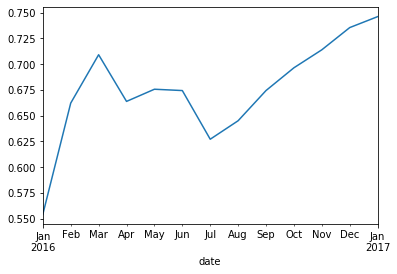

In [28]:
calendar_vacancy= calendar[['available']].groupby(pd.Grouper(freq="M")).mean().rename(columns = {'available':'vacancy'})
calendar_vacancy.vacancy.plot(kind = 'line');


In [ ]:
calendar_availability = calendar[['date','available']].groupby('date',as_index=False).sum()

calendar_occupancy_bf17 = calendar_availability[calendar_availability.date < datetime.datetime.strptime('2017-01-01', '%Y-%m-%d')]

calendar_occupancy_bf17['date'] = pd.to_datetime(calendar_occupancy_bf17['date'],format='%y-%m-d')


# Reviews

In [ ]:
reviews.head()

In [ ]:
listings.keys()

In [ ]:
(listings[['availability_365']]/365).hist();